In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Install required packages
!pip install ultralytics torch torchvision opencv-python pillow albumentations
!pip install matplotlib seaborn pandas numpy
!pip install -U scikit-learn scipy matplotlib

In [8]:
#Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix
import random
import shutil
from pathlib import Path
%ls

 Volume in drive C is OS
 Volume Serial Number is 7E85-ECD0

 Directory of C:\Users\vixlu\Documents\IAT 360

2025-10-22  03:48 PM    <DIR>          .
2025-10-22  03:43 PM    <DIR>          ..
2025-10-22  03:48 PM    <DIR>          weather-training-and-classification-project
               0 File(s)              0 bytes
               3 Dir(s)  974,134,951,936 bytes free


In [28]:
#Define paths and classes
class Config:
    DATA_PATH = "weather-training-and-classification-project/data"
    OUTPUT_PATH = "weather-training-and-classification-project"
    RUNS_PATH = "weather-training-and-classification-project/runs"
    CLASSES = ['cloudy', 'foggy', 'rainy', 'snowy', 'sunny']
    IMG_SIZE = 640
    BATCH_SIZE = 64
    EPOCHS = 2 #50 objective
    PRETRAINED_MODEL = 'yolo11n.pt'  # pre trained model
    BALANCE_DATASET = True
    TARGET_SAMPLES_PER_CLASS = 500  # Set to desired number or None for auto-balance
config = Config()

#Create directory structure
def setup_directories():
    os.makedirs(config.OUTPUT_PATH, exist_ok=True)
    os.makedirs(os.path.join(config.OUTPUT_PATH, "images", "train"), exist_ok=True)
    os.makedirs(os.path.join(config.OUTPUT_PATH, "images", "val"), exist_ok=True)
    os.makedirs(os.path.join(config.OUTPUT_PATH, "labels", "train"), exist_ok=True)
    os.makedirs(os.path.join(config.OUTPUT_PATH, "labels", "val"), exist_ok=True)

setup_directories()
print("Completed config")

Completed config


In [16]:
#Data augmentation functions
import albumentations as A

def create_augmentation_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.HueSaturationValue(p=0.3),
        A.RandomGamma(p=0.2),
        A.CLAHE(p=0.2),
        A.RandomRotate90(p=0.3),
        A.Transpose(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.Blur(blur_limit=3, p=0.2),
    ])

augmentation = create_augmentation_pipeline()
print("Completed augmentation")

Completed augmentation


C:\Users\vixlu\AppData\Local\Temp\ipykernel_20896\2166943248.py:14: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


In [17]:
def analyze_and_balance_dataset():
    """Analyze dataset distribution and balance classes"""
    class_counts = {}
    class_images = {}

    print("Analyzing dataset distribution...")

    for class_name in config.CLASSES:
        class_path = os.path.join(config.DATA_PATH, class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            class_counts[class_name] = len(images)
            class_images[class_name] = images
            print(f"{class_name}: {len(images)} images")
        else:
            print(f"Warning: {class_path} not found")
            class_counts[class_name] = 0
            class_images[class_name] = []

    if config.BALANCE_DATASET:
        if config.TARGET_SAMPLES_PER_CLASS is not None:
            target_count = config.TARGET_SAMPLES_PER_CLASS
        else:
            # Use the minimum count among all classes
            target_count = min(class_counts.values())

        print(f"\nBalancing dataset to {target_count} images per class...")

        # Balance each class
        for class_name in config.CLASSES:
            if class_counts[class_name] > target_count:
                # Randomly sample if we have too many images
                class_images[class_name] = random.sample(class_images[class_name], target_count)
                print(f"Reduced {class_name} from {class_counts[class_name]} to {len(class_images[class_name])} images")
            elif class_counts[class_name] < target_count:
                print(f"Warning: {class_name} has only {class_counts[class_name]} images, but target is {target_count}")
                # We'll use all available images, but you could add oversampling here
                print(f"Using all {class_counts[class_name]} available images for {class_name}")

    return class_images, target_count

In [18]:
#convert_to_yolo_format
def convert_to_yolo_format():
    # Create dataset.yaml file
    yaml_content = f"""
path: {os.path.abspath(config.OUTPUT_PATH)}
train: images/train
val: images/val

nc: {len(config.CLASSES)}
names: {config.CLASSES}
"""

    with open(os.path.join(config.OUTPUT_PATH, "dataset.yaml"), "w") as f:
        f.write(yaml_content)

    # Analyze and balance dataset
    class_images, target_count = analyze_and_balance_dataset()

    # Process each class
    for class_idx, class_name in enumerate(config.CLASSES):
        class_path = os.path.join(config.DATA_PATH, class_name)
        images = class_images[class_name]

        if not images:
            print(f"Warning: No images found for {class_name}")
            continue

        # Split data (80% train, 20% validation)
        random.shuffle(images)
        split_idx = int(0.8 * len(images))
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        print(f"Processing {class_name}: {len(train_images)} train, {len(val_images)} val")

        # Process training images (with augmentation)
        for img_name in train_images:
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue

            # Original image
            save_image_and_label(image, img_name, class_idx, "train")

            # Augmented images (create 2 additional versions)
            for aug_idx in range(2):
                augmented = augmentation(image=image)['image']
                aug_name = f"aug_{aug_idx}_{img_name}"
                save_image_and_label(augmented, aug_name, class_idx, "train")

        # Process validation images (no augmentation)
        for img_name in val_images:
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            save_image_and_label(image, img_name, class_idx, "val")

    print("Dataset conversion completed with balancing!")

def save_image_and_label(image, img_name, class_idx, split):
    # Save image
    img_save_path = os.path.join(config.OUTPUT_PATH, "images", split, img_name)
    cv2.imwrite(img_save_path, image)

    # Create YOLO format label (single class for whole image)
    label_save_path = os.path.join(config.OUTPUT_PATH, "labels", split,
                                  os.path.splitext(img_name)[0] + ".txt")

    # YOLO format: class_id x_center y_center width height
    # For classification, we use the entire image as bounding box
    height, width = image.shape[:2]
    x_center = 0.5
    y_center = 0.5
    bbox_width = 1.0
    bbox_height = 1.0

    with open(label_save_path, "w") as f:
        f.write(f"{class_idx} {x_center} {y_center} {bbox_width} {bbox_height}")

# Convert the dataset
convert_to_yolo_format()
print("Dataset conversion completed!")

Analyzing dataset distribution...
cloudy: 6702 images
foggy: 1260 images
rainy: 1927 images
snowy: 1875 images
sunny: 6274 images

Balancing dataset to 500 images per class...
Reduced cloudy from 6702 to 500 images
Reduced foggy from 1260 to 500 images
Reduced rainy from 1927 to 500 images
Reduced snowy from 1875 to 500 images
Reduced sunny from 6274 to 500 images
Processing cloudy: 400 train, 100 val
Processing foggy: 400 train, 100 val
Processing rainy: 400 train, 100 val
Processing snowy: 400 train, 100 val
Processing sunny: 400 train, 100 val
Dataset conversion completed with balancing!
Dataset conversion completed!


In [19]:
# Visualize some samples with augmentation
def visualize_samples():
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for i, class_name in enumerate(config.CLASSES):
        class_path = os.path.join(config.DATA_PATH, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if images:
            # Original image
            img_path = os.path.join(class_path, images[0])
            original_img = cv2.imread(img_path)
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

            # Augmented image
            augmented_img = augmentation(image=original_img)['image']

            axes[0, i].imshow(original_img)
            axes[0, i].set_title(f'Original: {class_name}')
            axes[0, i].axis('off')

            axes[1, i].imshow(augmented_img)
            axes[1, i].set_title(f'Augmented: {class_name}')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples()

In [29]:
# Initialize YOLO model
def setup_model():
    model = YOLO(config.PRETRAINED_MODEL)
    return model

model = setup_model()
print("Model loaded successfully!")

Model loaded successfully!


In [30]:
# Train the model
def train_model():
    results = model.train(
        data=os.path.join(config.OUTPUT_PATH, "dataset.yaml"),
        epochs=config.EPOCHS,
        imgsz=config.IMG_SIZE,
        batch=config.BATCH_SIZE,
        patience=10,
        save=True,
        device=0 if torch.cuda.is_available() else 'cpu',
        workers=20,
        lr0=0.01,  # Initial learning rate
        lrf=0.01,  # Final learning rate factor
        momentum=0.937,
        weight_decay=0.0005,
        warmup_epochs=3.0,
        box=7.5,   # Box loss gain
        cls=0.5,   # Class loss gain
        hsv_h=0.015,  # Image HSV-Hue augmentation
        hsv_s=0.7,    # Image HSV-Saturation augmentation
        hsv_v=0.4,    # Image HSV-Value augmentation
        degrees=0.0,  # Image rotation
        translate=0.1,  # Image translation
        scale=0.5,     # Image scale
        shear=0.0,     # Image shear
        perspective=0.0,  # Image perspective
        flipud=0.0,    # Image flip up-down
        fliplr=0.5,    # Image flip left-right
        mosaic=1.0,    # Image mosaic
        mixup=0.0,     # Image mixup
        copy_paste=0.0,  # Segment copy-paste
    )
    return results

training_results = train_model()

Ultralytics 8.3.220  Python-3.13.9 torch-2.9.0+cpu CPU (12th Gen Intel Core i7-12700H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=weather-training-and-classification-project\dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, persp

In [37]:
# Evaluate the model
def evaluate_model():
    # Load the best model from training
    best_model_path = config.RUNS_PATH+"/detect/train4/weights/best.pt"
    model = YOLO(best_model_path)

    # Validate on validation set
    metrics = model.val(
        data=os.path.join(config.OUTPUT_PATH, "dataset.yaml"),
        split='val',
        imgsz=config.IMG_SIZE,
        batch=config.BATCH_SIZE,
        conf=0.25,
        iou=0.45
    )

    return metrics, model

metrics, best_model = evaluate_model()
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")

Ultralytics 8.3.220  Python-3.13.9 torch-2.9.0+cpu CPU (12th Gen Intel Core i7-12700H)
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 340.3169.9 MB/s, size: 30.6 KB)
val: Scanning C:\Users\vixlu\Documents\IAT 360\weather-training-and-classification-project\labels\val.cache... 968 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 968/968 1.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 0.5it/s 35.4s
                   all        968        968      0.708      0.755        0.8      0.779
                cloudy        199        199      0.651      0.789      0.729       0.72
                 foggy        186        186      0.372      0.968      0.879      0.873
                 rainy        193        193      0.882      0.543      0.745      0.724
                 snowy        195        195      0.764      0.826      0.852

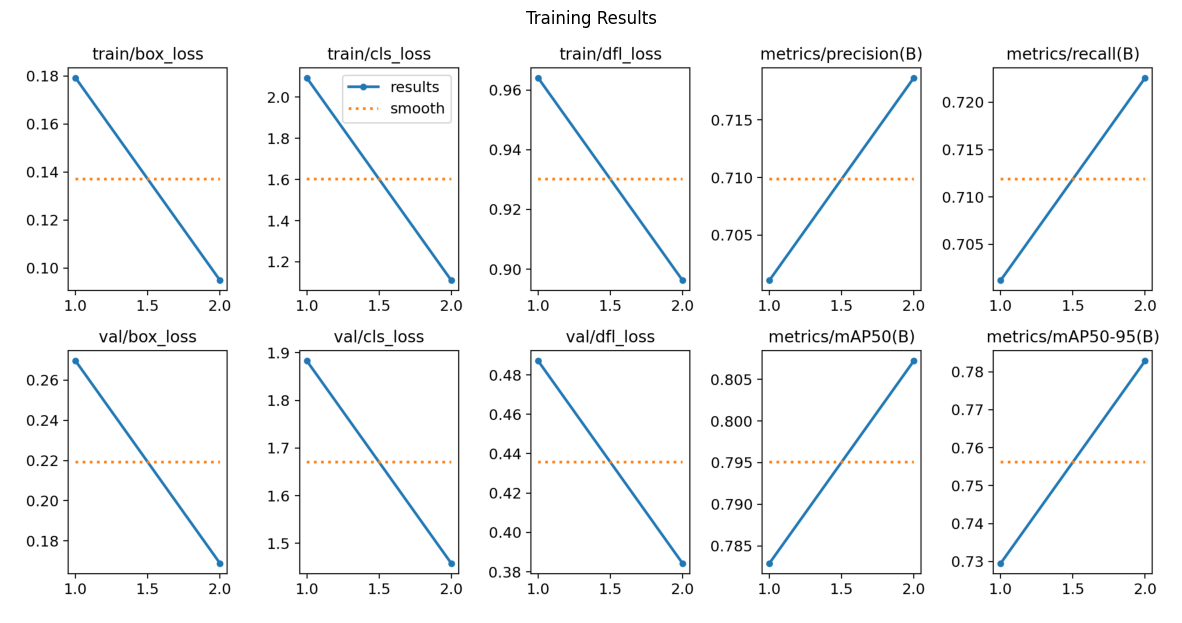

In [39]:
# Plot training results
def plot_training_results():
    # Construct the path to the results.png file within the latest experiment directory
    # The experiment name is 'train' by default as specified in the train_model function
    results_path = os.path.join(config.RUNS_PATH, "detect", "train4", "results.png")

    if os.path.exists(results_path):
        results_img = cv2.imread(results_path)
        results_img = cv2.cvtColor(results_img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(15, 10))
        plt.imshow(results_img)
        plt.axis('off')
        plt.title('Training Results')
        plt.show()
    else:
        print(f"Results plot not found at {results_path}. Make sure the training was successful.")

plot_training_results()

In [39]:
# Fine-tuning function for further training
def fine_tune_model(additional_epochs=1, learning_rate=0.0001):#change additional epochs to ~20 later if desired
    best_model_path = config.RUNS_PATH+"/detect/train4/weights/best.pt"
    model = YOLO(best_model_path)

    fine_tune_results = model.train(
        data=os.path.join(config.OUTPUT_PATH, "dataset.yaml"),
        epochs=additional_epochs,
        imgsz=config.IMG_SIZE,
        batch=config.BATCH_SIZE,
        device=0 if torch.cuda.is_available() else 'cpu',
        lr0=learning_rate,
        resume=True,  # Continue from best checkpoint
        patience=5,
        save=True,
        name='fine_tune'  # Save in separate directory
    )

    return fine_tune_results, model

# Uncomment to run fine-tuning
fine_tune_results, fine_tuned_model = fine_tune_model(additional_epochs=20, learning_rate=0.0001)


image 1/1 C:\Users\vixlu\Documents\IAT 360\weather-training-and-classification-project\internet_test_images\test_internet.jpg: 448x640 1 cloudy, 1 sunny, 111.3ms
Speed: 5.7ms preprocess, 111.3ms inference, 3.3ms postprocess per image at shape (1, 3, 448, 640)
Predicted: cloudy (confidence: 0.5527)


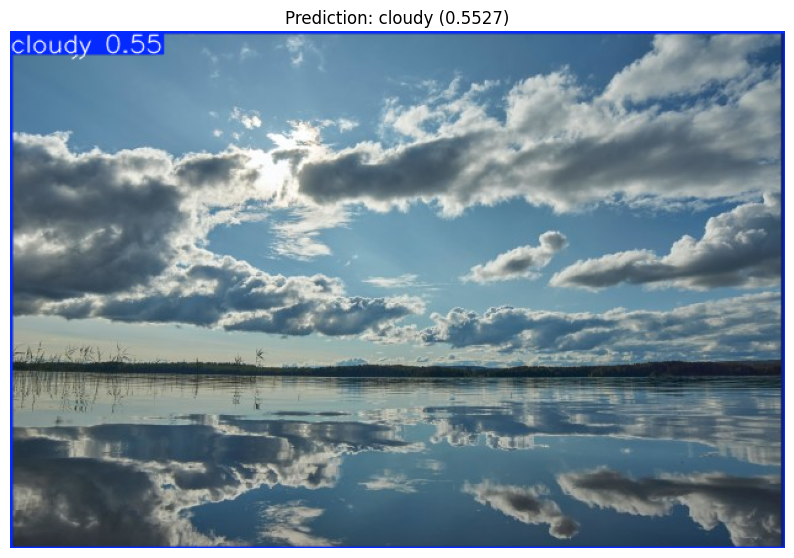

Predicted: sunny (confidence: 0.4743)



image 1/1 C:\Users\vixlu\Documents\IAT 360\weather-training-and-classification-project\internet_test_images\test_internet_2.jpg: 448x640 1 foggy, 72.1ms
Speed: 1.8ms preprocess, 72.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)
Predicted: foggy (confidence: 0.8636)



image 1/1 C:\Users\vixlu\Documents\IAT 360\weather-training-and-classification-project\internet_test_images\test_internet_3.jpg: 384x640 1 sunny, 73.0ms
Speed: 1.3ms preprocess, 73.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Predicted: sunny (confidence: 0.5789)


In [40]:
# Function to test on single image
def predict_weather(image_path, model_path=None):
    if model_path is None:
        model_path = config.RUNS_PATH+"/detect/train4/weights/best.pt"

    model = YOLO(model_path)

    # Perform prediction
    results = model(image_path, conf=0.25)

    # Process results
    for r in results:
        boxes = r.boxes
        if boxes is not None and len(boxes) > 0:
            for box in boxes:
                cls = int(box.cls[0])
                conf = float(box.conf[0])
                class_name = config.CLASSES[cls]
                print(f"Predicted: {class_name} (confidence: {conf:.4f})")

                # Display image with prediction
                img = r.plot()
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(10, 8))
                plt.imshow(img_rgb)
                plt.axis('off')
                plt.title(f'Prediction: {class_name} ({conf:.4f})')
                plt.show()
        else:
            print("No predictions found")

    return results

# Test on a sample images taken from internet
sample_image_path = "weather-training-and-classification-project/internet_test_images/test_internet.jpg"
results = predict_weather(sample_image_path)
sample_image_path2 = "weather-training-and-classification-project/internet_test_images/test_internet_2.jpg"
results2 = predict_weather(sample_image_path2)
sample_image_path3 = "weather-training-and-classification-project/internet_test_images/test_internet_3.jpg"
results3 = predict_weather(sample_image_path3)

In [41]:
# Export model to different formats
def export_model(model_path=None):
    if model_path is None:
        model_path = config.RUNS_PATH+"/detect/train4/weights/best.pt"

    model = YOLO(model_path)

    # Export to different formats
    export_formats = ['onnx', 'torchscript']  # You can add more formats

    for fmt in export_formats:
        try:
            exported_path = model.export(format=fmt)
            print(f"Model exported to {exported_path}")
        except Exception as e:
            print(f"Failed to export to {fmt}: {e}")

export_model()

Ultralytics 8.3.220  Python-3.13.9 torch-2.9.0+cpu CPU (12th Gen Intel Core i7-12700H)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11n summary (fused): 100 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'weather-training-and-classification-project\runs\detect\train4\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
   ---------------------------------------- 0.0/16.5 MB ? eta -:--:--
   -------------------------------- ------- 13.4/16.5 MB 70.6 MB/s eta 0:00:01
   ---------------------------------------- 16.5/16.5 MB 69.2 MB/s  0:00:00
   ---------------------------------------- 0.0/13.5 MB ? eta -:--:--
   -------------------------------------- - 12.8/13.5 MB 61.5 MB/s eta 0:00:01
  

In [43]:
# Detailed evaluation with confusion matrix
def detailed_evaluation():
    model_path = config.RUNS_PATH+"/detect/train4/weights/best.pt"
    model = YOLO(model_path)

    # Get validation directory
    val_dir = os.path.join(config.OUTPUT_PATH, "images", "val")

    all_predictions = []
    all_true_labels = []

    for class_idx, class_name in enumerate(config.CLASSES):
        class_images = [f for f in os.listdir(val_dir)
                       if f.startswith(class_name) or f"aug_" in f]

        for img_name in class_images:
            img_path = os.path.join(val_dir, img_name)
            results = model(img_path, verbose=False)

            for r in results:
                boxes = r.boxes
                if boxes is not None and len(boxes) > 0:
                    pred_class = int(boxes.cls[0])
                    all_predictions.append(pred_class)
                    all_true_labels.append(class_idx)

    # Generate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=config.CLASSES, yticklabels=config.CLASSES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_true_labels, all_predictions,
                              target_names=config.CLASSES))

detailed_evaluation()


Classification Report:
              precision    recall  f1-score   support

      cloudy       0.83      0.79      0.81        19
       foggy       0.78      0.95      0.86        38
       rainy       0.96      0.77      0.86        31
       snowy       0.87      0.94      0.90        35
       sunny       1.00      0.50      0.67         8

    accuracy                           0.85       131
   macro avg       0.89      0.79      0.82       131
weighted avg       0.87      0.85      0.85       131



In [ ]:
# Complete usage example
'''
def setup_complete_pipeline():
    """Setup complete pipeline for weather classification"""

    # 1. Setup directories and convert data
    print("Setting up directories...")
    setup_directories()

    # 2. Convert dataset to YOLO format
    print("Converting dataset to YOLO format...")
    convert_to_yolo_format()

    # 3. Initialize and train model
    print("Initializing model...")
    model = setup_model()

    # 4. Train the model
    print("Starting training...")
    training_results = train_model()

    # 5. Evaluate the model
    print("Evaluating model...")
    metrics, best_model = evaluate_model()

    print(f"\n=== Training Complete ===")
    print(f"Best mAP50: {metrics.box.map50:.4f}")
    print(f"Best mAP50-95: {metrics.box.map:.4f}")

    return best_model
'''
# Uncomment to run the complete pipeline
# final_model = setup_complete_pipeline()